# Organic matter decomposition kinetics in cranberry agroecosystem using the Tea Bag Index

*Wilfried Dossou-Yovo, Serge Étienne Parent, Noura Ziadi, Élizabeth Parent and Léon Étienne Parent*

In [1]:
print(Sys.Date())

[1] "2021-04-08"


## 1. Objective

This notebook generates the results included in the manuscript *Organic matter decomposition kinetics in cranberry agroecosystem using the Tea Bag Index*. Two trials have been made, first one in 2017 (data_2017.csv) and the second in 2018 (data_2018.csv).Data set from trials are a collection of incubated tea bag weight, nitrogen, carbon and sulfur content, nitrogen type and doses on trials fieds. The aims of this study was to assess soil carbon sequestration capacity of cranberry stands in eastern Canada.

## 2. Statistical questions

In addition to data exploration, this notebook will answer the following statistical questions.

1. What affecting TBI parameters (k)?
2. Where cranberry soils are placed among the axes of the *TBI*?
3. What is the fractal kinetics of litter matterials ?
4. What is the fractal kinetics of litter biochemical composition ?

## 3. Packages and Function

### 3.1 Packages

We need package [tidyverse](https://www.tidyverse.org/) which loads a set of packages for easy data manipulation (e.g. [dplyr](https://www.rdocumentation.org/packages/dplyr/versions/0.7.8)) and visualization (e.g. [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.2.1)). A set of other packages is used: [nlme](https://www.rdocumentation.org/packages/nlme/versions/3.1-143/topics/nlme) for fitting nonlinear mixed-effects models, the [broom](https://www.rdocumentation.org/packages/broom/versions/0.7.0) package summarises model outputs in a "tidy" way, [e1071](https://www.rdocumentation.org/packages/e1071/versions/1.7-3) to test distributions, [ggmap](https://www.rdocumentation.org/packages/ggmap/versions/3.0.0) for mapping, [ggrepel](https://www.rdocumentation.org/packages/ggrepel/versions/0.8.1) to avoid text overlaping on ggplot2, [patchwork](https://www.rdocumentation.org/packages/patchwork/versions/1.0.0/topics/patchwork-package) to assemble plots in grids, [composition](https://www.rdocumentation.org/packages/compositions/versions/1.40-5) for compositional data transformations.

In [2]:
library("tidyverse")
library("nlme")
library("broom")
library("e1071")
library("ggmap")
library("ggrepel")
library("patchwork")
library("compositions")

Warning message:
"package 'tidyverse' was built under R version 3.6.2"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.3.2     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.2"Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'readr' was built under R version 3.6.2"Warning message:
"package 'purrr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"Warning message:
"package 'stringr' was built under R version 3.6.2"Warning message:
"package 'forcats' was built under R version 3.6.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning mess

## 3.2 Some custom functions.
### Pseudo R-square
Pseudo R-square allows to measure how well variables of our model explain organic matter decomposition

In [3]:
pseudoR2 <- function(y, y_hat) {
  1 - (sum((y - y_hat)^2) / sum((y - mean(y))^2))
}

# Residuals
residues <- function(model, level = 0, computeResidues = TRUE, residues,
                   main = "") {
  if (computeResidues) {
    r = residuals(model, type="normalized", level)
  } else {
    r = residues
  }
  hist(r, freq=F, main = main, breaks=20)
  xfit<-seq(min(r),max(r),length=40)
  yfit<-dnorm(xfit)
  lines(xfit, yfit, col="red", lwd=2)
  print("Shapiro-Wilk:")
  print(shapiro.test(r))
  print(paste("Kurtosis:", kurtosis(r)))
  print(paste("Skewness:", skewness(r)))
}

## 4. Import data
Here, we load our data `data.csv` available for the project in the `data` folder.

In [4]:
df <- read_csv("data/data_2017.csv")

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_double(),
  No = col_double(),
  `Tea type abbr` = col_character(),
  `Tea type` = col_character(),
  `Initial tea weight (g)` = col_double(),
  `Initial total weight (g)` = col_double(),
  `Initial bag weight (g)` = col_double(),
  `Remaining tea weight (g)` = col_double(),
  Farm = col_character(),
  Site = col_character(),
  `Farming system` = col_character(),
  `Nitrogen type` = col_character(),
  `Nitrogen dose` = col_double(),
  Repetition = col_double(),
  `Remaining C (%)` = col_double(),
  `Remaining N (%)` = col_double(),
  `Remaining S (%)` = col_double(),
  `Initial C fraction` = col_double()
)


We create a label `Dose repetition` to create unique identifiers for blocks.

In [5]:
df$`Dose repetition` <- paste0(df$`Nitrogen dose`, '_', df$Repetition,'_', df$Site)

*Cranberry litter* category will be used for the reference category in modeling.

In [6]:
df$`Tea type` <- relevel(factor(df$`Tea type`), ref = 'Cranberry litter')

## 5. Mapping experimental sites

We design a map of our four experimental sites with geographical position collected from Stamen maps. Warnings appear, but it seems its a bug that comes out when mixing ggmap and geom_label_repel.

Source : http://tile.stamen.com/toner-lite/4/3/4.png
Source : http://tile.stamen.com/toner-lite/4/4/4.png
Source : http://tile.stamen.com/toner-lite/4/5/4.png
Source : http://tile.stamen.com/toner-lite/4/3/5.png
Source : http://tile.stamen.com/toner-lite/4/4/5.png
Source : http://tile.stamen.com/toner-lite/4/5/5.png
Source : http://tile.stamen.com/toner-lite/8/76/90.png
Source : http://tile.stamen.com/toner-lite/8/77/90.png
Source : http://tile.stamen.com/toner-lite/8/76/91.png
Source : http://tile.stamen.com/toner-lite/8/77/91.png
Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"Warning message in min(x):
"aucun argument trouvé pour min ; Inf est renvoyé"Warning message in max(x):
"aucun argument pour max ; -Inf est renvoyé"Warning message in

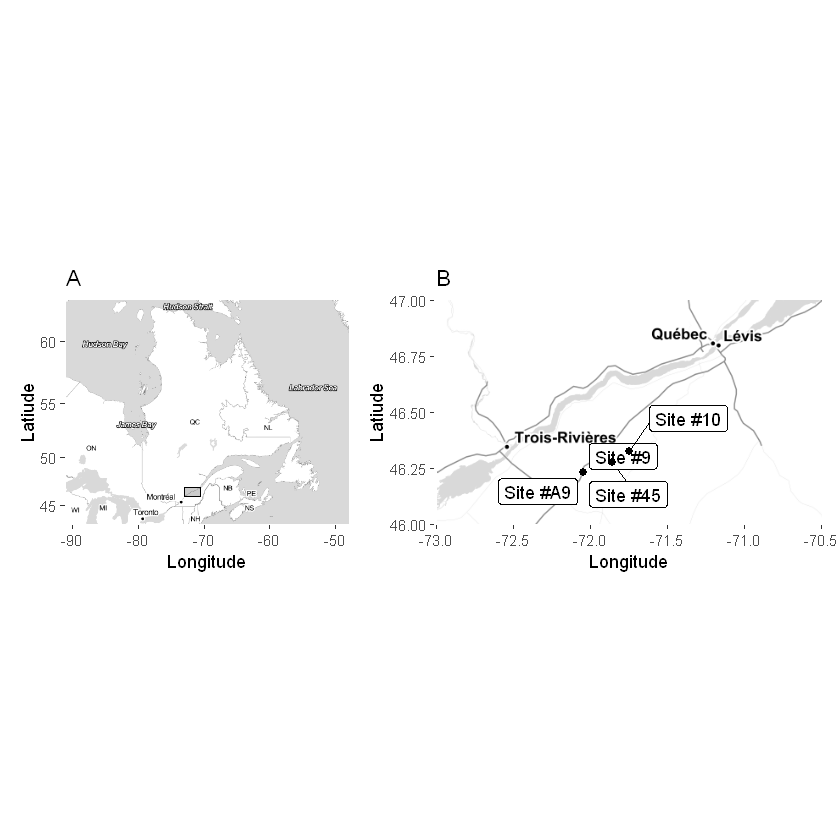

In [7]:
# table including sites and their geograhic position
sites <- tibble(names = c("Site #45", "Site #9", "Site #A9", "Site #10"),
                lat = c(46.2759555, 46.2759555, 46.2329064, 46.3277404),
                lon = c(-71.8584291, -71.8584291, -72.0461854, -71.7486645))

# create two frames, one for zoom out, the other for zoom in
frame_map_zoom_out <- c(left = -91, bottom = 43, right = -48, top = 63)
frame_map_zoom_in <- c(left = -73, bottom = 46, right = -70.5, top = 47)

# to draw the zoom in frame on the zoom out map
rect_zoom <- data.frame(t(data.frame(frame_map_zoom_in)))

# the map with zoom out
map_out <- get_stamenmap(frame_map_zoom_out, zoom = 4, maptype = "toner-lite") %>%
  ggmap() +
  geom_rect(data = rect_zoom, aes(xmin = left, xmax = right,
                                  ymin = bottom, ymax = top,
                                  x = NULL, y = NULL),
            fill = rgb(0, 0, 0, 0.2), colour = "black") +
  #geom_label_repel(data = sites, aes(x = lon, y = lat, label = names)) +
  labs(x = "Longitude", y = "Latiude", title = "A")

# the map with zoom in
map_in <- get_stamenmap(frame_map_zoom_in, zoom = 8, maptype = "toner-lite") %>%
  ggmap() +
  geom_label_repel(data = sites, aes(x = lon, y = lat, label = names)) +
 geom_point(aes(x = lon, y = lat), data = sites, size = 2) +
  labs(x = "Longitude", y = "Latiude", title = "B")

# combining the plots
maps_ <- map_out + map_in
maps_
ggsave("figures/site_map.png", plot = maps_, width = 8, height = 6, dpi = 600)

## 6. Monthly weather data (2008-2018) at Lemieux, Quebec (46° 09′ 56″ N 72° 19′ 28″ W), for experimental sites (Gouvernement du Canada, 2018)

### 6.1 Import data weather

`Data weather` has been collected from environnement canada. The content is the collection of data history about temperature and precipitation from years of field trial (2017 and 2018) and 10 years average (2008 to 2018).

In [8]:
df_weather <- read_csv2("data/data_weather.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  Years = col_character(),
  Months = col_character(),
  `Precipitations (mm)` = col_double(),
  `Temperatures (<U+00B0>C)` = col_double()
)


### 6.2 Plot weather data

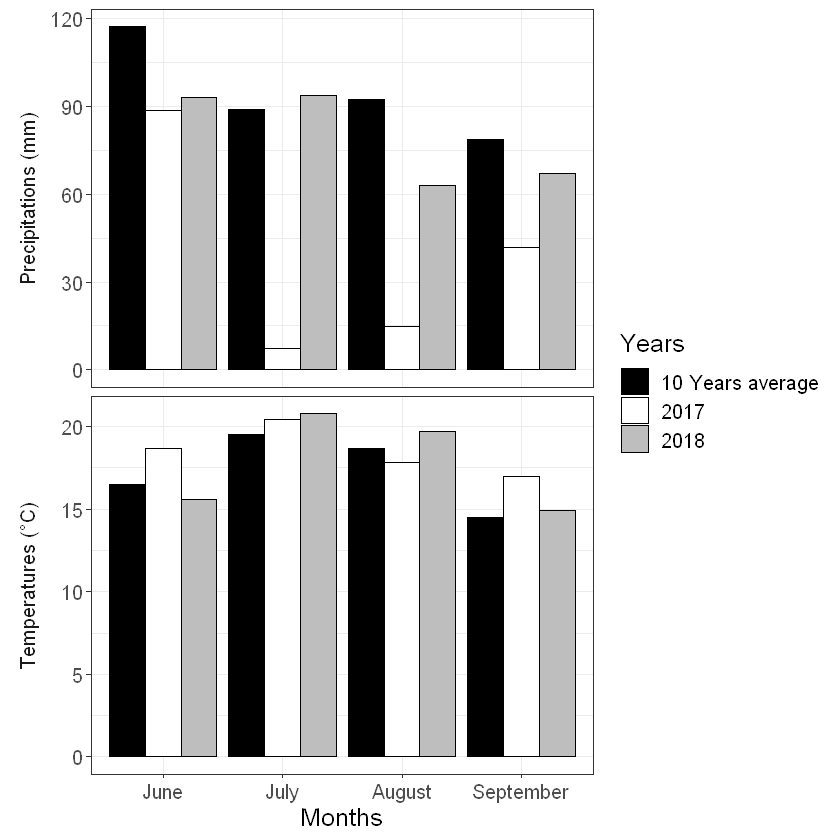

In [9]:
df_weather$Months <- factor(df_weather$Months,levels = c("June", "July", "August", "September")) #  Sorting bars by Months

df_weather_long <- df_weather %>%
  pivot_longer(cols = -c(Years, Months))

Weather <- df_weather_long %>%
  filter(Years %in% c("2017", "2018", "10 Years average")) %>%
  ggplot(aes(x = `Months`, y = value)) +
  facet_grid(name ~ ., scales = "free", switch = "y") +
  geom_bar(aes(fill= Years), colour = "black", stat="identity", position="dodge") +
  theme_bw() +
scale_fill_manual(values = c("black","white","grey")) +
  theme(axis.title.y = element_blank(),
        strip.background = element_rect(fill = "transparent", colour = "transparent"),
        strip.placement = "outside", text = element_text(size = 15))
Weather
ggsave("figures/Weather.png", plot = Weather, width = 7, height = 6, dpi = 120)

## 7. Compute the 1st order kinetics

Weight loss rate has been estimated with the function

$k_1 = \frac{-ln \left( \frac{M(t)}{M_0} \right) }{t}$,

where $M_0$ is initial litter organic mass, $M(t)$ is litter organic mass that remains after incubation time $t = 90~days$, and $k_1$ is decomposition rate. 

In [10]:
kinetics_1st <- function(rw, iw, t) { # First order kinetic function
    -log(rw/iw)/t
}

We can compute `k1` for each row of the `df` table.

In [11]:
df$k1 <- kinetics_1st(rw = df$`Remaining tea weight (g)`,
                      iw = df$`Initial tea weight (g)`,
                      t = 90)

## 8. Data exploration

Boxplot of $k_1$ for different N dosages per litter.

Warning message:
"Removed 23 rows containing non-finite values (stat_boxplot)."

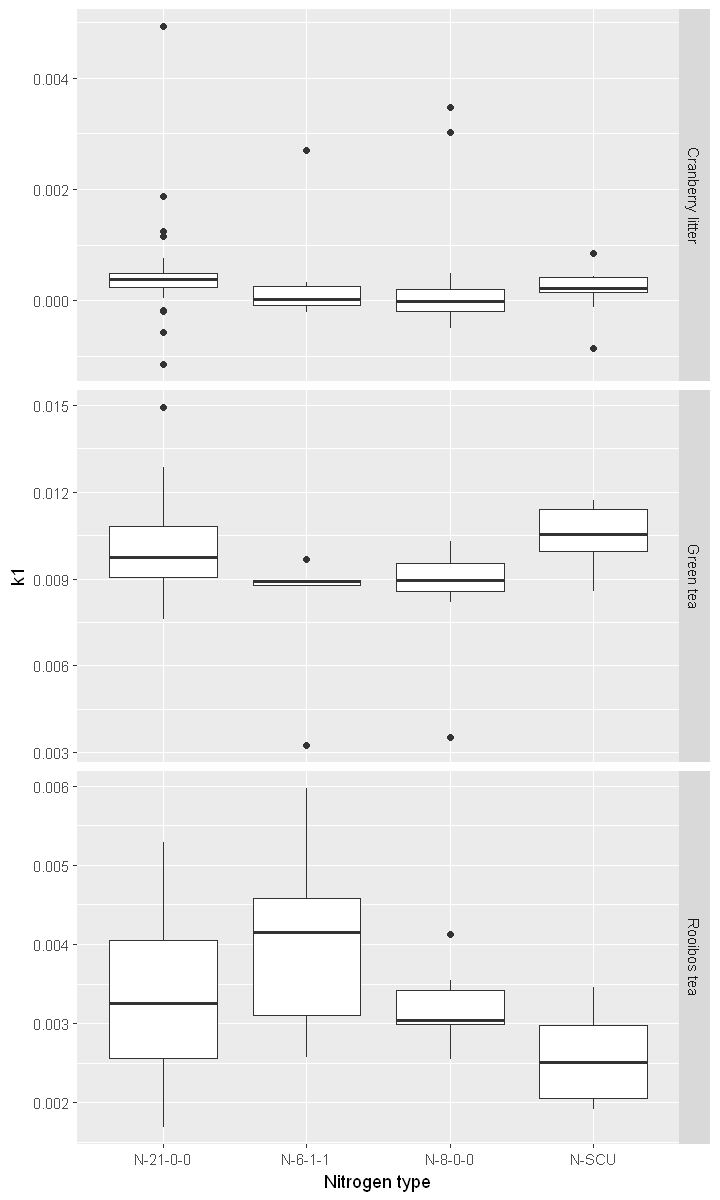

In [12]:
options(repr.plot.width = 6, repr.plot.height = 10)
ggplot(data = df,
       mapping = aes(x = `Nitrogen type`, y = k1)) +
  facet_grid(`Tea type` ~ ., scales = "free") +
  geom_boxplot()

## 9. Mixed model

## 9.1 **Question 1**: What affected TBI parameters (k and S)?

Adding `M / M0` variable to data `df`.

In [13]:
df <- df %>%
  mutate(`M / M0` = `Remaining tea weight (g)` / `Initial tea weight (g)`)

I store hydrolysable fractions of green tea and rooibos.

In [14]:
Hf_g <- 0.805   # Hydrolysable fraction for Green tea
Hf_r <- 0.826   # Hydrolysable fraction for Rooibos tea

For comparaison purpose, [Keuskamp et al. (2013)](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.12097) hydrolysable fractions were:

- Green tea `Hf_g = 0.842`  
- Rooibos tea `Hf_r = 0.552`

### 9.1.1 Computation of the labile fraction (a) and the stabilization factor (s) of green tea

Decomposition rate `k_tbi` is computed from Rooibos tea after 90 days of incubation. The *TBI* assumes that the decomposition of Green tea has stablilized while Rooibos tea is still decomposing. Stabilization factor `S` is computed from Green tea.

In [15]:
df <- df %>%
  mutate(a = ifelse(`Tea type` == "Green tea",
                    (`Initial tea weight (g)` - `Remaining tea weight (g)`) / `Initial tea weight (g)`,
                    NA),
         S = 1 - a / Hf_g)

Compute litter stability `Sg` (Green tea) and decomposition constant `k_tbi` (Rooibos) for each experimental unit.

In [16]:
df <- df %>%
  mutate(sdr = paste(df$Site, df$`Nitrogen dose`, df$Repetition))
sdr_u <- unique(df$sdr)

In [17]:
# Initialize k_tbi column
df$k_tbi <- NA

# For each rep, compute a and k_tbi
for (i in 1:length(sdr_u)) {
  # Green tea
  Sg_i <- mean(df$S[df$sdr == sdr_u[i] & df$`Tea type` == "Green tea"], na.rm = TRUE)
  
  # Rooibos
  df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- Hf_r * (1 - Sg_i)
  ar_i <- df$a[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  M_M0i <- df$`M / M0`[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"]
  df$k_tbi[df$sdr == sdr_u[i] & df$`Tea type` == "Rooibos tea"] <- log(ar_i / (M_M0i - (1-ar_i))) / 90
}

Data exploration for N dose type.

Warning message:
"Removed 186 rows containing missing values (geom_point)."

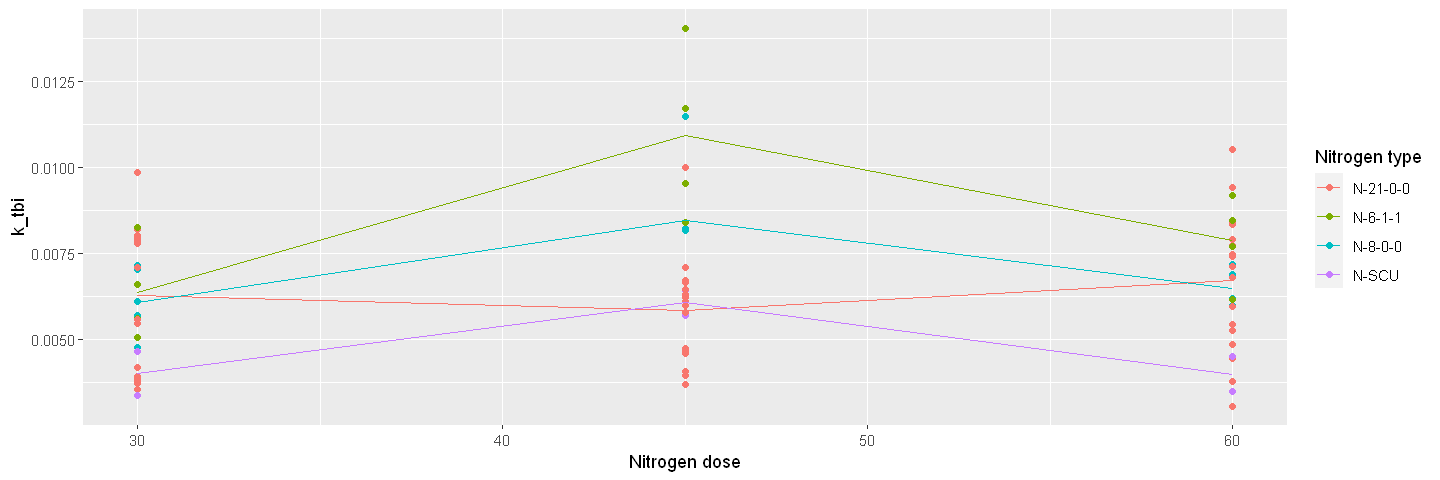

In [18]:
options(repr.plot.width=12, repr.plot.height=4)
ggplot(data = df,
       mapping = aes(x = `Nitrogen dose`, y = k_tbi)) +
  geom_point(aes(colour = `Nitrogen type`)) +
  geom_line(data = . %>%
    group_by(`Nitrogen dose`, `Nitrogen type`) %>%
    summarise(k_tbi = mean(k_tbi, na.rm = TRUE)),
           aes(colour = `Nitrogen type`))

### 9.2 What affecting TBI parameter decomposition rate (k)?

Because `k_tbi` is computed from Rooibos tea, we create a new Rooibos data table named `df_rooibos`.

In [19]:
df_rooibos <- df %>% 
  filter(`Tea type` == "Rooibos tea")

TBI_data <- df %>%
  select(k_tbi, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

TBI_rooibos <- TBI_data %>%
  filter(`Tea type` == "Rooibos tea")

### 9.2.1 `k_tbi` mixed model

lme_TBI model investigates the magnitude of the dose (`Ndose`) on `k_tbi`, considering the random effect of sites (`Site`)

In [20]:
TBI_rooibos <- TBI_rooibos %>%
mutate(log = log(k_tbi))
lme_TBI <- lme (log ~  Ndose, 
               random = ~ 1 | Site, 
    data = TBI_rooibos)

In [21]:
summary(lme_TBI)

Linear mixed-effects model fit by REML
 Data: TBI_rooibos 
       AIC      BIC    logLik
  29.23211 38.90747 -10.61605

Random effects:
 Formula: ~1 | Site
        (Intercept)  Residual
StdDev:   0.2274628 0.2395634

Fixed effects: log ~ Ndose 
                Value  Std.Error DF   t-value p-value
(Intercept) -5.198405 0.15038005 80 -34.56845  0.0000
Ndose        0.003086 0.00211625 80   1.45825  0.1487
 Correlation: 
      (Intr)
Ndose -0.631

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-2.42462710 -0.65390187 -0.07675473  0.60081810  2.92740766 

Number of Observations: 85
Number of Groups: 4 

### 9.2.2 Pseudo r-square

Pseudo r-square was 0.01 with and 0.45 without random effect indicated the influence of random effects was impotant. 

In [22]:
pseudoR2(y = TBI_rooibos$log,
         y_hat = predict(lme_TBI, level = 0))

pseudoR2(y = TBI_rooibos$log,
         y_hat = predict(lme_TBI, level = 1))

[1] 0.01107845

[1] 0.4530537

### 9.2.3 Shapiro-Wilk normality test
Our data were normaly distributed as shown by the following residues plot 

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.98693, p-value = 0.5511

[1] "Kurtosis: -0.324713934613358"
[1] "Skewness: -0.121097388651243"


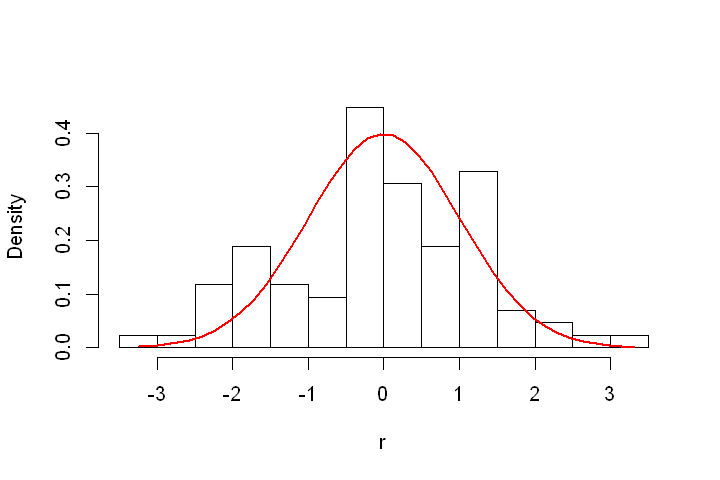

In [23]:
options(repr.plot.width = 6, repr.plot.height = 4)
residues(lme_TBI)

### 9.2.4 Reporting the results of the mixed models
I create a table including the results I need: estimates, confidence intervals and p-values.

In [24]:
k_tbi_gg <- data.frame(intervals(lme_TBI, which = "fixed")$fixed)
k_tbi_gg <- k_tbi_gg %>%
  mutate(variable = rownames(k_tbi_gg))
k_tbi_gg <- k_tbi_gg %>%
  mutate(pvalue = summary(lme_TBI)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Adding random effects to the table.

In [25]:
k_tbi_re <- data.frame(matrix(ncol = ncol(k_tbi_gg), nrow = 4))
names(k_tbi_re) <- names(k_tbi_gg)
k_tbi_re$est. <- ranef(lme_TBI)$`(Intercept)`
k_tbi_re$variable <- rownames(ranef(lme_TBI))
k_tbi_re

if (!("Belanger" %in% k_tbi_gg$variable)) k_tbi_gg <- bind_rows(k_tbi_gg, k_tbi_re) # with an if to make sure ranefs are stacked only once

lower,est.,upper,variable,pvalue,is_significant
NA,-0.33187047,NA,10,NA,NA
NA,0.12770506,NA,45,NA,NA
NA,0.11076003,NA,9,NA,NA
NA,0.09340537,NA,A9,NA,NA


In [26]:
k_tbi_gg$variable <- c("Intercept",  # Change variable names
                        "Dose N",
                        "site #10", "site #45", "site #9", "site #A9")

Create a facet column to separate effects by effect category in the plot.

In [27]:
k_tbi_gg$facet <- factor(c('Intercept',
                        "Nitrogen dose",
                           "Random effect", "Random effect", "Random effect", "Random effect"))

k_tbi_gg <- k_tbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", 
                                              "Nitrogen dose", "Intercept"))))
k_tbi_gg

lower,est.,upper,variable,pvalue,is_significant,facet
-5.497670873,-5.198405035,-4.899139197,Intercept,7.349407e-50,Significant at 0.05 level,Intercept
-0.001125443,0.003086023,0.007297489,Dose N,1.486858e-01,Not significant at 0.05 level,Nitrogen dose
NA,-0.331870467,NA,site #10,NA,NA,Random effect
NA,0.127705060,NA,site #45,NA,NA,Random effect
NA,0.110760034,NA,site #9,NA,NA,Random effect
NA,0.093405373,NA,site #A9,NA,NA,Random effect


The `k_tbi_gg` table is now set up for the plot.

Warning message:
"Removed 4 rows containing missing values (geom_segment)."Warning message:
"Removed 4 rows containing missing values (geom_segment)."

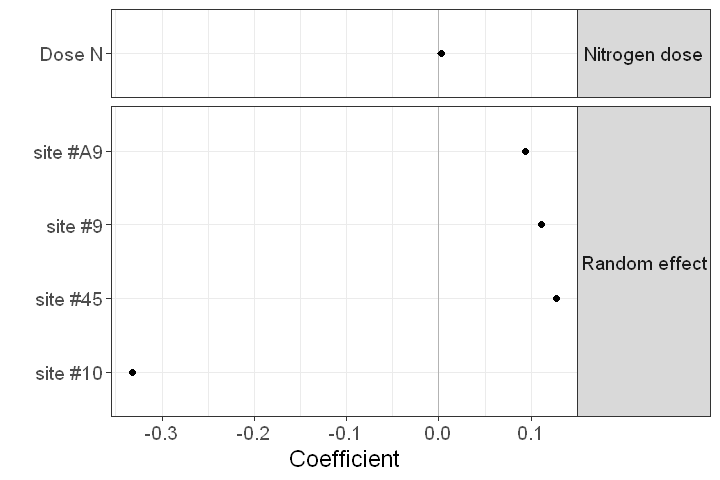

In [28]:
options(repr.plot.width = 6, repr.plot.height = 4)
k_tbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 14)) +
  ggsave("figures/k_tbi-mixed-model-coefficients.png", width = 6, height = 2, dpi = 600)

### 9.3 What affecting TBI parameter stabilization factor (S)?

Because `S` is computed from Green tea, we create a new Green data table named `df_green`.

In [29]:
df_green <- df %>% 
  filter(`Tea type` == "Green tea")

S_data <- df %>%
  select(S, `Tea type`, Farm, `Nitrogen dose`, Site,
         `Nitrogen type`) %>%
  rename(Ntype = `Nitrogen type`,
         Ndose = `Nitrogen dose`) %>%
  drop_na() %>%
  droplevels()

S_Green <- S_data %>%
  filter(`Tea type` == "Green tea")

### 9.3.1 `S` mixed model

lme_S model investigates the magnitude of the dose (`Ndose`) on `S`, considering the random effect of sites (`Site`)

In [30]:
S_Green <- S_Green %>%
mutate(log = log(S))
lme_S <- lme (log ~  Ndose, 
               random = ~ 1 | Site, 
    data = S_Green)

In [31]:
summary(lme_S)

Linear mixed-effects model fit by REML
 Data: S_Green 
       AIC      BIC    logLik
  24.93149 34.40928 -8.465746

Random effects:
 Formula: ~1 | Site
        (Intercept)  Residual
StdDev:   0.2008001 0.2342948

Fixed effects: log ~ Ndose 
                 Value  Std.Error DF   t-value p-value
(Intercept) -1.3626927 0.14210876 76 -9.589083    0.00
Ndose        0.0013701 0.00217167 76  0.630888    0.53
 Correlation: 
      (Intr)
Ndose -0.683

Standardized Within-Group Residuals:
        Min          Q1         Med          Q3         Max 
-4.08191446 -0.39071373 -0.02084241  0.41862266  3.16880092 

Number of Observations: 81
Number of Groups: 4 

### 9.3.2 Pseudo r-square

Pseudo r-square was 0.01 with and 0.4 without random effect indicated the influence of random effects was impotant. 

In [32]:
pseudoR2(y = S_Green$log,
         y_hat = predict(lme_S, level = 0))

pseudoR2(y = S_Green$log,
         y_hat = predict(lme_S, level = 1))

[1] 0.005017486

[1] 0.3917774

### 9.3.3 Shapiro-Wilk normality test
Our data were normaly distributed as shown by the following residues plot 

[1] "Shapiro-Wilk:"

	Shapiro-Wilk normality test

data:  r
W = 0.90532, p-value = 1.844e-05

[1] "Kurtosis: 4.01438471717064"
[1] "Skewness: -0.467798066057914"


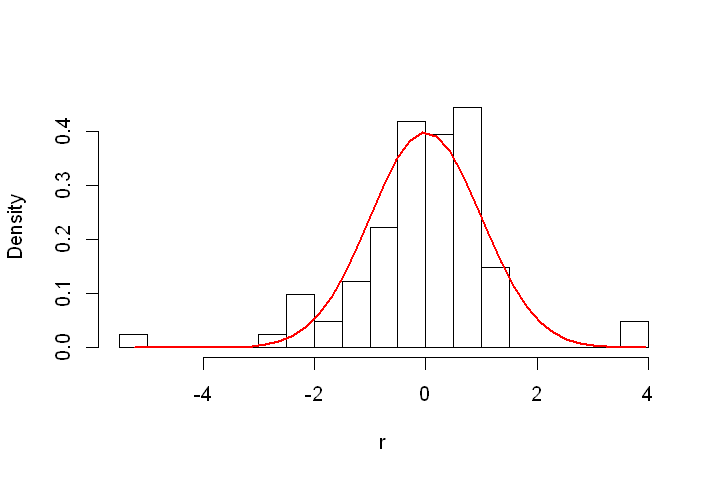

In [33]:
options(repr.plot.width = 6, repr.plot.height = 4)
residues(lme_S)

### 9.3.4 Reporting the results of the mixed models
I create a table including the results I need: estimates, confidence intervals and p-values.

In [34]:
S_tbi_gg <- data.frame(intervals(lme_S, which = "fixed")$fixed)
S_tbi_gg <- S_tbi_gg %>%
  mutate(variable = rownames(S_tbi_gg))
S_tbi_gg <- S_tbi_gg %>%
  mutate(pvalue = summary(lme_S)$tTable[, 5],
         is_significant = ifelse(pvalue <= 0.05, 'Significant at 0.05 level', 'Not significant at 0.05 level'))

Adding random effects to the table.

In [35]:
S_tbi_re <- data.frame(matrix(ncol = ncol(S_tbi_gg), nrow = 4))
names(S_tbi_re) <- names(S_tbi_gg)
S_tbi_re$est. <- ranef(lme_S)$`(Intercept)`
S_tbi_re$variable <- rownames(ranef(lme_S))
S_tbi_re

if (!("Belanger" %in% S_tbi_gg$variable)) S_tbi_gg <- bind_rows(S_tbi_gg, S_tbi_re) # with an if to make sure ranefs are stacked only once

lower,est.,upper,variable,pvalue,is_significant
NA,-0.003696603,NA,10,NA,NA
NA,0.089219883,NA,45,NA,NA
NA,-0.268151265,NA,9,NA,NA
NA,0.182627986,NA,A9,NA,NA


In [36]:
S_tbi_gg$variable <- c("Intercept",  # Change variable names
                        "Dose N",
                        "site #10", "site #45", "site #9", "site #A9")

Create a facet column to separate effects by effect category in the plot.

In [37]:
S_tbi_gg$facet <- factor(c('Intercept',
                        "Nitrogen dose",
                           "Random effect", "Random effect", "Random effect", "Random effect"))

S_tbi_gg <- S_tbi_gg %>%
  mutate(facet = factor(facet, levels = rev(c("Random effect", 
                                              "Nitrogen dose", "Intercept"))))
S_tbi_gg

lower,est.,upper,variable,pvalue,is_significant,facet
-1.645726830,-1.362692702,-1.079658574,Intercept,1.001048e-14,Significant at 0.05 level,Intercept
-0.002955178,0.001370082,0.005695343,Dose N,5.300065e-01,Not significant at 0.05 level,Nitrogen dose
NA,-0.003696603,NA,site #10,NA,NA,Random effect
NA,0.089219883,NA,site #45,NA,NA,Random effect
NA,-0.268151265,NA,site #9,NA,NA,Random effect
NA,0.182627986,NA,site #A9,NA,NA,Random effect


The `S` table is now set up for the plot.

Warning message:
"Removed 4 rows containing missing values (geom_segment)."Warning message:
"Removed 4 rows containing missing values (geom_segment)."

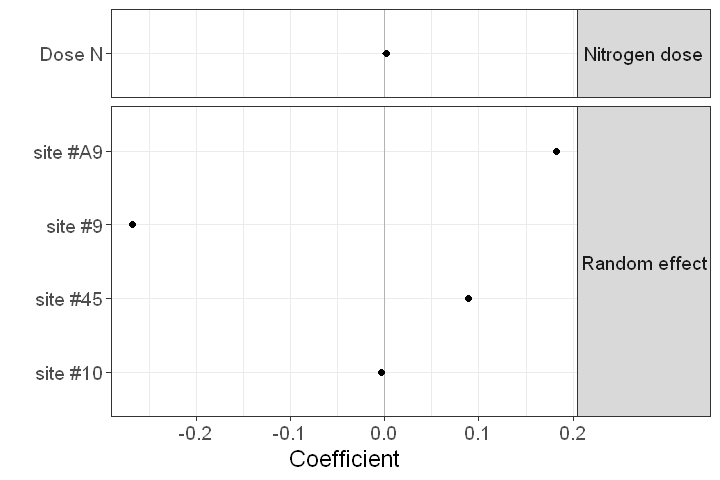

In [38]:
options(repr.plot.width = 6, repr.plot.height = 4)
S_tbi_gg %>%
  filter(variable != "Intercept") %>%
  ggplot(aes(x = est., y = variable)) +
  facet_grid(facet ~ ., scales = 'free', space = 'free') +
  geom_vline(xintercept = 0, colour='grey70') +
  geom_point() +
  geom_segment(aes(x = lower, xend = upper, y = variable, yend = variable)) +
  xlab('Coefficient') +
  ylab('') +
  theme_bw() +
  theme(strip.text.y = element_text(angle=0),
        legend.title = element_blank(),
        legend.position = "bottom",
        text = element_text(size = 14)) +
  ggsave("figures/S_tbi-mixed-model-coefficients.png", width = 6, height = 2, dpi = 600)

## 10. **Question 2**: Where cranberry soils are placed among the axes of the *TBI*?

Here, we extracted data from Keuskamp et al.2013 in order to compare with cranberry ecosystem

### 10.1 Import data

We adapted keuskamp's data by adding cranberry ecosystem

In [39]:
df_keuskamp <- read_csv("data/keuskamp_tbi_data.csv")# Import Keuskamp data

Parsed with column specification:
cols(
  Nombre = col_double(),
  Region = col_character(),
  Stabilisation_factor_S = col_double(),
  Decomposition_rate_K = col_double()
)


Create a logic column (`is_cranberry`) in order to identify `Cranberries` by color in the plot below

In [40]:
df_keuskamp <- df_keuskamp %>%
  mutate(is_cranberry = Region == "Cranberries")

### 10.2 Figure TBI

TBI of Quebec cranberry agroecosystem compared to the TBI of ecosystems reported by Keuskamp et al 2013. United States–Florida = US-FL, China = CN, Panama = PA, the Netherlands = NL, Austria = AU, Ireland = IE, and Iceland = IS.

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."

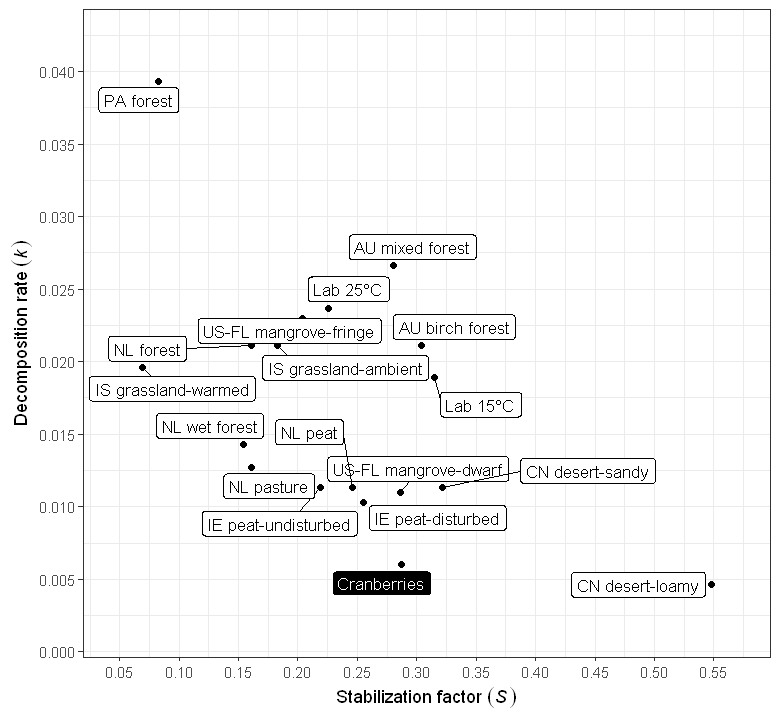

In [41]:
options(repr.plot.width = 6.5, repr.plot.height = 6)
ggplot(data = df_keuskamp, aes(x = Stabilisation_factor_S, y = Decomposition_rate_K)) +
  geom_point() +
scale_x_continuous(breaks = 0.05*0:1000,
                   expand = expand_scale(add = 0.05)) +
scale_y_continuous(breaks = 0.005*0:1000,
                   expand = expand_scale(add = 0.005)) +
  geom_label_repel(aes(label = Region, fill = is_cranberry, colour = is_cranberry),
                   size = 3.5) +
  scale_fill_manual(values = c("white", "black")) +
  scale_colour_manual(values = c("black", "white")) +
  theme_bw() +
  theme(legend.position = "none") +
  labs(x = expression(paste("Stabilization factor ",(italic("S")))), y = expression(paste("Decomposition rate ", (italic("k"))))) +
  ggsave("figures/TBI_keuskamp.png", width = 6, height = 6, dpi = 120)

### 11. **Question 3**:What is the fractal kinetics of litter matterials ?

Depending on the nature of decaying material and its immediate environment, the decomposition rate of plant residues can decrease gradually through time as follow: 

$$k_t = k_1 t^{{-h}}$$

$$log \left( k_t \right) = log \left( k_1 t^{-h} \right)$$

$$log \left( k_t \right) = log \left( k_1 \right) + log \left(t^{-h} \right)$$

$$log \left( k_t \right) = log \left( k_1 \right) - h \times log \left(t\right)$$

Where $k_t$ is first order kinetics, $k_1$ is reaction rate at time t = 1 and $h$ is a fractal coefficient (0 ≤ h ≤ 1) accounting for the decreasing decomposition rate through time

#### 11.1 Fractal coefficient computation

##### 11.1.1 Import data

Fractal data set from 2018 trial contained information on `Final carbon (%)` `Final weight (g)` `Initial weight (g)` `Initial carbon (%)`   

In [42]:
data_fractal <- read_csv2("data/data_fractal.csv")

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  `Tea type` = col_character(),
  Prelevement = col_double(),
  `Final carbon (%)` = col_double(),
  `Final weight (g)` = col_double(),
  `Initial weight (g)` = col_double(),
  `Initial carbon (%)` = col_double()
)


##### 11.1.1 Adding some variables
`First order kinetic names (k)`, `log(k)` and `Log(t)` has been computed. Then we select the variables needed in order compute the fractal coefficient `h`

In [43]:
data_lm_fractal <- data_fractal %>%
  mutate(
    # time and k
    time = Prelevement * 21,
    k = -log(`Final weight (g)` / `Initial weight (g)`)/ time,
  ) %>%
  mutate(
    # log.time and log.k
    log.time = log10(time),
    log.k = log10(k)
  ) %>%
  select(`Tea type`, `k`,`log.time`, `log.k`, `time`)

Warning message:
"production de NaN"

Then, we create data to store the results `intercept`, `slope` and r square `r_sq`

In [44]:
fractal_kinetics <- tibble(
    tea_types = c("Rooibos tea", "Cranberry litter", "Green tea"),
    intercept_ll = NA,
    intercept = NA,
    intercept_ul = NA,
    slope_ll = NA,
    slope = NA,
    slope_ul = NA,
    r_sq = NA
)

```
lm(log.k ~ log.time)
k1 = 10^intercept
h = -slope
```


Computation of median value of `log.time` and `log.k` by `time` and `tea type` to determine `h`

In [45]:
data_median_lm_fractal <- aggregate(cbind(log.time, log.k) ~ time + `Tea type`, data = data_lm_fractal, FUN = median)

Applying `lm` in a loop `for` in order to compute `h`, r square `r_sq` and `k1` by `tea type`

In [46]:
conf_level <- 0.95

for (i in 1:nrow(fractal_kinetics)) {
    
    lm_fractal <- data_median_lm_fractal %>%
      filter(`Tea type` == fractal_kinetics$tea_types[i]) %>%
      lm(log.k ~ log.time, data = .)
    
    # intercept
    fractal_kinetics$intercept_ll[i] <- confint(lm_fractal, level = conf_level)[1, 1]
    fractal_kinetics$intercept[i] <- coef(lm_fractal)[1]
    fractal_kinetics$intercept_ul[i] <- confint(lm_fractal, level = conf_level)[1, 2]
    
    # Slope
    fractal_kinetics$slope_ll[i] <- confint(lm_fractal, level = conf_level)[2, 1]
    fractal_kinetics$slope[i] <- coef(lm_fractal)[2]
    fractal_kinetics$slope_ul[i] <- confint(lm_fractal, level = conf_level)[2, 2]
    
    # statistics
    fractal_kinetics$r_sq[i] <- summary(lm_fractal)$r.squared
}

In [47]:
fractal_kinetics <-  fractal_kinetics %>%
  mutate(h_ll = -slope_ul,
         h = -slope,
         h_ul = -slope_ll,
         k1_ll = 10^intercept_ll,
         k1 = 10^intercept,
        k1_ul = 10^intercept_ul)%>%
  select(tea_types, r_sq, h_ll, h, h_ul, k1_ll, k1, k1_ul)

In [48]:
fractal_kinetics

tea_types,r_sq,h_ll,h,h_ul,k1_ll,k1,k1_ul
Rooibos tea,0.9390858023,0.2584239,0.3654122,0.4724005,1.117193e-02,0.0177156624,0.02809224
Cranberry litter,0.0004111749,-1.1554032,0.0207501,1.1969034,4.652317e-06,0.0007393424,0.11749569
Green tea,0.9943128412,0.6377774,0.6985075,0.7592375,1.523378e-01,0.1979084002,0.25711108


Fractal first order parameters of teas and cranberry litter decomposition under field conditions

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


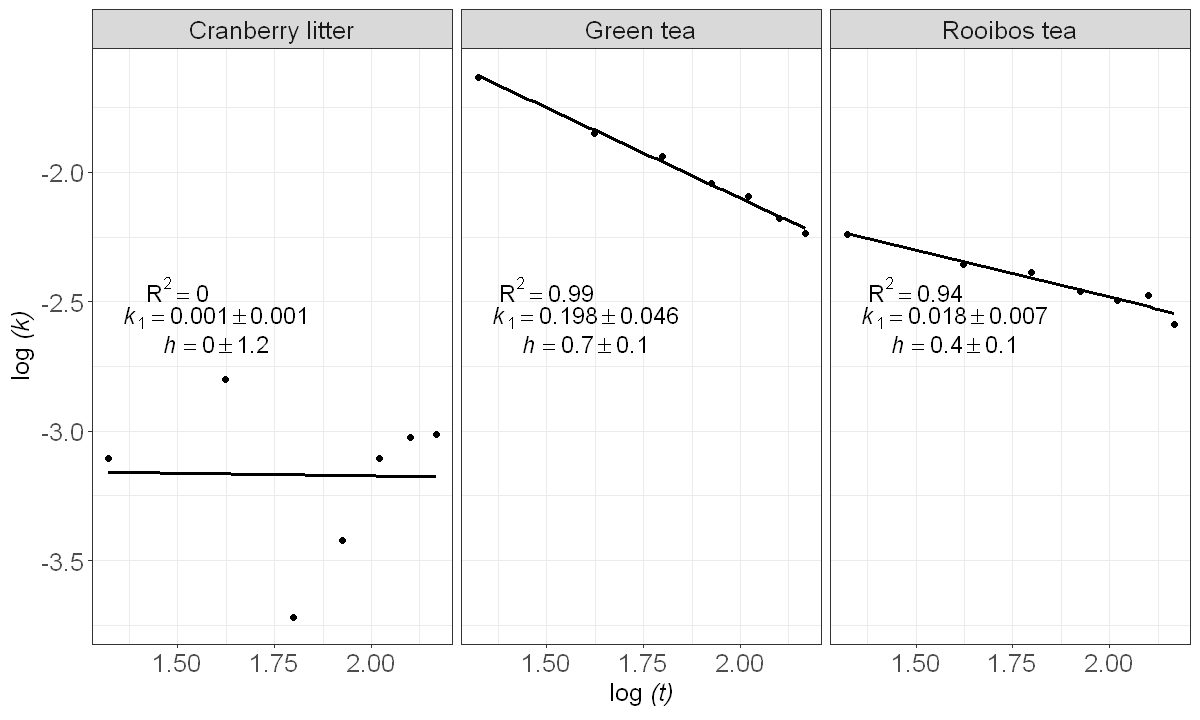

In [49]:
options(repr.plot.width = 10, repr.plot.height = 6)
data_median_lm_fractal %>%
  ggplot(aes(x = log.time, y  = log.k)) +
  geom_point() + geom_smooth(method = "lm", se = FALSE, colour="black") +
  facet_grid(. ~ `Tea type`) +
  geom_text(data = fractal_kinetics %>%
              rename(`Tea type`= tea_types),
            parse = TRUE,
            aes(label = paste("italic(h) ==", round(h, 1), "%+-%", round(h-h_ll, 1))),
            x = 1.60, y = -2.66, size = 5) +
  geom_text(data = fractal_kinetics %>%
              rename(`Tea type`= tea_types),  
            parse = TRUE,
            aes(label = paste(("italic(k[1]) =="), round(k1, 3), "%+-%", round(k1- k1_ll, 3))),
            x = 1.60, y = -2.56, size = 5) +
geom_text(data = fractal_kinetics %>%
              rename(`Tea type`= tea_types),
          parse = TRUE,
            aes(label = paste(("R^2 =="), round(r_sq, 2))),
            x = 1.5, y = -2.45, size = 5) +
labs(x = expression(paste("log ",italic("(t)"))), y=expression(paste("log ",italic("(k)")))) +
  theme_bw() + 
theme(strip.text = element_text(size = 15), axis.text=element_text(size=15),
        axis.title=element_text(size=15)) 
ggsave("figures/Fractal first order parameters of teas and cranberry litter decomposition under field conditions.png", width = 8, height = 6, dpi = 600)

Mean and standard deviation of first order kinetics

In [50]:
data_fractal_mean <- aggregate(`k` ~ `Tea type`, data = data_lm_fractal, FUN = mean)
data_fractal_mean
data_fractal_sd <- aggregate(`k` ~ `Tea type`, data = data_lm_fractal, FUN = sd)
data_fractal_sd
data_fractal_length <- aggregate(`k` ~ `Tea type`, data = data_lm_fractal, FUN = length)
data_fractal_length
error_cranberry <- qnorm(0.975)*data_fractal_sd[1,2]/sqrt(data_fractal_length[1,2])
error_cranberry
error_green <- qnorm(0.975)*data_fractal_sd[2,2]/sqrt(data_fractal_length[2,2])
error_green
error_rooibos <- qnorm(0.975)*data_fractal_sd[3,2]/sqrt(data_fractal_length[3,2])
error_rooibos

Tea type,k
Cranberry litter,7.491976e-05
Green tea,1.148394e-02
Rooibos tea,3.977654e-03


Tea type,k
Cranberry litter,0.001614161
Green tea,0.005593548
Rooibos tea,0.001449430


Tea type,k
Cranberry litter,768
Green tea,936
Rooibos tea,909


[1] 0.0001141601

[1] 0.0003583418

[1] 9.422442e-05

## 11.3.4 Estimation of the carbon decreasing rate of teas and cranberry residue

Reaction rate $k_1$ at time t = 1 and fractal coefficient $h$

In [51]:
k1_rooibos <- fractal_kinetics %>%
  filter(tea_types == "Rooibos tea") %>%
  pull(k1)

k1_green <- fractal_kinetics %>%
  filter(tea_types == "Green tea") %>%
  pull(k1)

k1_cranberry <- fractal_kinetics %>%
  filter(tea_types == "Cranberry litter") %>%
  pull(k1)

h_rooibos <- fractal_kinetics %>%
  filter(tea_types == "Rooibos tea") %>%
  pull(h)

h_green <- fractal_kinetics %>%
  filter(tea_types == "Green tea") %>%
  pull(h)

h_cranberry <- fractal_kinetics %>%
  filter(tea_types == "Cranberry litter") %>%
  pull(h)

Computing  $k_t$ for each tea type and renaming somes variables to be able to group plot

$$k_t = k_1 t^{{-h}}$$

In [52]:
data_rate <- data.frame(Prelevement = 1:7) %>%
                            mutate(`Time (days)` = Prelevement * 21,
                                  `Rate cranberry` = k1_cranberry *  `Time (days)`**-h_cranberry,
                                  `Rate rooibos` = k1_rooibos * `Time (days)`**-h_rooibos,
                                  `Rate green` = k1_green * `Time (days)`**-h_green) %>%
                            rename(`Cranberry litter` = `Rate cranberry`,
                                  `Rooibos tea` = `Rate rooibos`,
                                   `Green tea` = `Rate green`)

Tranforming data_rate into long format data in order to generate the plot

In [53]:
data_long <- gather(data = data_rate, key = `tea type`, value = Rate, c(`Cranberry litter`, `Rooibos tea`, `Green tea`),
                    factor_key=TRUE)
data_long <- data_long %>%
             rename(`Litter type`= `tea type`)

Plot of litter decomposition rate over time under field conditions

Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."Warning message:
"`expand_scale()` is deprecated; use `expansion()` instead."

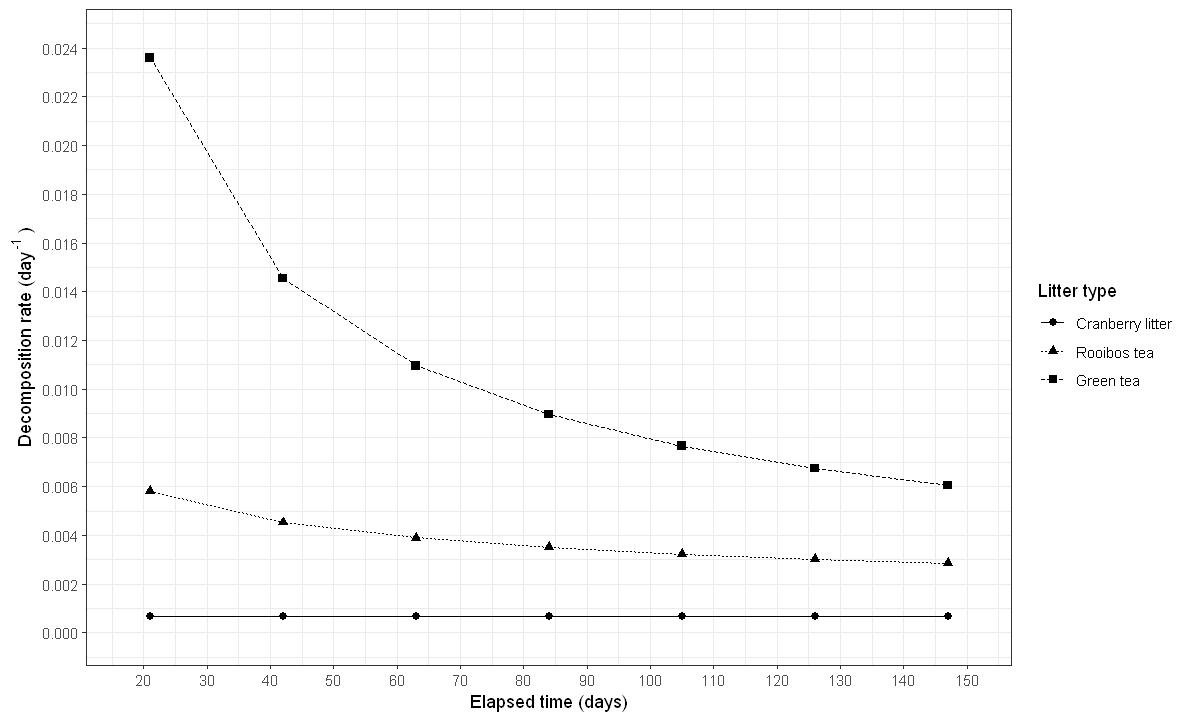

In [54]:
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(data_long, aes(x = `Time (days)`, y = `Rate`, group = `Litter type`)) +
geom_line(aes(linetype= `Litter type`)) +
geom_point(aes(shape = `Litter type`), size = 2)+
#geom_smooth(method = "lm", formula = y ~ poly(x, 6) , color = 'grey', se = FALSE) + 
labs(x = "Elapsed time (days)" , y = expression("Decomposition rate (day"^" -1"~")"))  +
theme(axis.title.x = element_text(size = 14), 
  axis.title.y = element_text(size = 14),
     legend.text=element_text(size=14)) +
scale_y_continuous(breaks = 0.002*0:1000,
                     expand = expand_scale(add = 0.002)) +
scale_x_continuous(breaks = 10*0:1000,
                     expand = expand_scale(add = 10)) +
theme_bw() +
ggsave("figures/K(t).png", width = 6, height = 4, dpi = 120)

## 12. **Question 4**: What is the fractal kinetics of litter biochemical composition ?

### 12.1 Biochemical composition data analysis 
Here, we load `data.csv`, `data_fiber_initial.csv` and `data_fiber.csv`available for the project in the `data` folder. The `data_2018.csv` contained incubation tea bag details and soil carateristics from the second essay in 2018; `data_fiber_initial.csv` contained only initial tea bag caracteristics and `data_fiber.csv` contained mostly tea bag biochemical details as soluble, holocellulose and lignin content. 
We wanted to use only data about `green tea`, `rooibos tea` and `cranberry residu`. In order to do that, we used `subset` function to get `data_subset`

In [55]:
data <- read_csv2('data/data_2018.csv', col_types = "??????????????f????????????????????")
data_fiber <- read_csv('data/data_fiber.csv')
data_fiber_initial <- read_csv('data/data_fiber_initial.csv')

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.
Parsed with column specification:
cols(
  `Iden fiber` = col_character(),
  `SOL perc ILR (%)` = col_double(),
  `HOLO perc ILR (%)` = col_double(),
  `LIC perc ILR (%)` = col_double()
)
Parsed with column specification:
cols(
  `Biomass type` = col_character(),
  `SOL perc initial (%)` = col_double(),
  `HOLO perc initial (%)` = col_double(),
  `LIC perc initial (%)` = col_double()
)


In [56]:
data_subset <- subset(data,  (`Sampling period (3 weeks)`> 0 & (`Biomass type`== "Cranberry residu" | 
`Biomass type` == "Green tea"| `Biomass type` == "Rooibos tea")))

Join all 3 data with with `left_join` function. The obtained data is called `data_join_02`

In [57]:
data_join <- data_subset %>%
  left_join(data_fiber, by = 'Iden fiber')

data_join_02 <- data_join %>%
  left_join(data_fiber_initial, by = 'Biomass type')%>%
mutate(`Sample final weight (g)` = as.numeric(`Sample final weight (g)`),
       `Sample final weight (g)` = as.numeric(`Sample final weight (g)`),
       `Sample final weight (g)` = as.numeric(`Sample final weight (g)`))

## 12.2 Some calculations 
### Initial and final content of carbon, soluble, holocellulose and lignin

In [58]:
data_join_02 <- data_join_02 %>%
mutate(`Initial SOL content (g)` = `SOL perc initial (%)` * `Sample initial weight (g)` / 100,
       `Initial HOLO content (g)` = `HOLO perc initial (%)` * `Sample initial weight (g)` / 100,
       `Initial LIC content (g)` = `LIC perc initial (%)` * `Sample initial weight (g)` / 100,
       `Final SOL content (g)` = `SOL perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final LIC content (g)` = `LIC perc ILR (%)` * `Sample final weight (g)` / 100,
       `Final HOLO content (g)` = `HOLO perc ILR (%)` * `Sample final weight (g)` / 100,
       `Initial Hydrolyzable content (g)` = `Initial SOL content (g)` +  `Initial HOLO content (g)`,
       `Final Hydrolyzable content (g)` = `Final SOL content (g)` + `Final HOLO content (g)`)

### 12.2.1 First order kinetic
Here,we compute decomposition rate of carbon, soluble, holocellulose and lignin using first order kinetic.

In [59]:
kinetics_1st <- function(rw, iw, t) { # first order kinetic function
    -log10(rw/iw)/t
}

In [60]:
data_join_02 <- data_join_02 %>%
mutate(`rate SOL` = kinetics_1st(rw = `Final SOL content (g)`,
                      iw = `Initial SOL content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate HOLO` = kinetics_1st(rw = `Final HOLO content (g)`,
                      iw = `Initial HOLO content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate LIC` = kinetics_1st(rw = `Final LIC content (g)`,
                      iw = `Initial LIC content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
       `rate Hydrolyzable` = kinetics_1st(rw = `Final Hydrolyzable content (g)`,
                      iw = `Initial Hydrolyzable content (g)`,
                      t = `Sampling period (3 weeks)` * 21),
      `Sampling period (days)` = `Sampling period (3 weeks)` * 21)

### 12.2.2 Selection all variables we interested in data_join_02. Our final data is called `data_filtre`

In [61]:
na.action = na.exclude
data_filtre <- data_join_02 %>%
select(`Iden fiber`, `Biomass type`,  `Sampling period (days)`, `Site`, `Producer`,`Repetition`,
 `Initial SOL content (g)`, `Initial HOLO content (g)`, `Initial LIC content (g)`, `Final SOL content (g)`,`Final HOLO content (g)`, `Final LIC content (g)`,
       `Sample final weight (g)`, `Initial Hydrolyzable content (g)`, `Final Hydrolyzable content (g)`,
       `rate SOL`, `rate HOLO`, `rate LIC`, `rate Hydrolyzable`) %>% 
rename(Lignin = `rate LIC`, 
       Holocelulose = `rate HOLO`, 
       Soluble = `rate SOL`,
       Hydrolyzable = `rate Hydrolyzable`)

## 12.3 Biochemical fractal kinetics

Transforming `data_filtre` to long format data `data_long` in order to use a `facet_grid` in the plot below

In [62]:
data_long <- gather(data = data_filtre, key = `Biochemical composition`, value = `Biochemical decomposition rate`, c(`Soluble`,
                                                                                                                    `Lignin`, `Holocelulose`, `Hydrolyzable`),
                    factor_key=TRUE)

Extract data_long according to biomass type `Rooibos and Green tea`; and Biochemical composition `Lignin and Hydrolyzable` fraction

In [63]:
data_long <- subset(data_long, `Biomass type` == "Green tea" | `Biomass type` == "Rooibos tea")
data_long <- subset(data_long, `Biochemical composition` == "Lignin" | `Biochemical composition` == "Hydrolyzable")

In [64]:
data_long <- data_long %>%
        mutate(`log.K` = log10(`Biochemical decomposition rate`),
                `log.T` = log10(`Sampling period (days)`))

Warning message:
"production de NaN"

Create new facet names for variable `Biochemical composition`

In [65]:
New.labs <- c("Non-Hydrolyzable", "Hydrolyzsable") 
names(New.labs) <- c("Lignin", "Hydrolyzable")

Selection of all variables needed in `data_lm_fractal_biochemical`

In [66]:
data_lm_fractal_biochemical <- data_long %>%
  select(`Biomass type`, `Biochemical decomposition rate`, `log.T`, `log.K`, `Biochemical composition`, `Sampling period (days)`)

Then, we create data to store the results `intercept`, `slope` and r square `r_sq`

In [67]:
fractal_biochemical_kinetics <- tibble(
    `Biomass type` = c("Green tea", "Rooibos tea", "Green tea", "Rooibos tea"),
    Biochemical_composition = c(rep("Lignin", 2), rep("Hydrolyzable", 2)),
    intercept_ll = NA,
    intercept = NA,
    intercept_ul = NA,
    slope_ll = NA,
    slope = NA,
    slope_ul = NA,
    r_sq = NA
)

```
lm(log.K ~ log.T)
K1 = 10^intercept
h = -slope
```


Computation of median value of `log.time` and `log.k` by `time` and `tea type` to determine `h`

In [68]:
data_median_fractal_biochemical <- aggregate(cbind(`log.T`, `log.K`) ~ `Sampling period (days)` + 
                                             `Biomass type` + `Biochemical composition`, 
                                             data = data_lm_fractal_biochemical, 
                                             FUN = median)

Applying `lm` in a loop `for` in order to compute `h`, r square `r_sq` and `k1`; by `Biomass type` and `Biochemical composition`

In [69]:
conf_level <- 0.95

for (i in 1:nrow(fractal_biochemical_kinetics)) {
    
    lm_fractal <- data_median_fractal_biochemical %>%
      filter((`Biomass type` == fractal_biochemical_kinetics$`Biomass type`[i]) &
             (`Biochemical composition` == fractal_biochemical_kinetics$Biochemical_composition[i])) %>%
      lm(`log.K` ~ `log.T`, data = .)
    
    # interept
    fractal_biochemical_kinetics$intercept_ll[i] <- confint(lm_fractal, level = conf_level)[1, 1]
    fractal_biochemical_kinetics$intercept[i] <- coef(lm_fractal)[1]
    fractal_biochemical_kinetics$intercept_ul[i] <- confint(lm_fractal, level = conf_level)[1, 2]
    
    # slope
    fractal_biochemical_kinetics$slope_ll[i] <- confint(lm_fractal, level = conf_level)[2, 1]
    fractal_biochemical_kinetics$slope[i] <- coef(lm_fractal)[2]
    fractal_biochemical_kinetics$slope_ul[i] <- confint(lm_fractal, level = conf_level)[2, 2]
    
    # statistics
    fractal_biochemical_kinetics$r_sq[i] <- summary(lm_fractal)$r.squared    
}

Computation of `h`, r square `r_sq` and `k1`; by `Biomass type` and `Biochemical composition`

In [70]:
fractal_biochemical_kinetics <- fractal_biochemical_kinetics %>%
  mutate(h_ll = -slope_ul,
         h = -slope,
         h_ul = -slope_ll,
         k1_ll = 10^intercept_ll,
         k1 = 10^intercept,
         k1_ul = 10^intercept_ul) %>%
  select(`Biomass type`,
         Biochemical_composition,
         r_sq,
         h_ll, h, h_ul,
         k1_ll, k1, k1_ul)
fractal_biochemical_kinetics

Biomass type,Biochemical_composition,r_sq,h_ll,h,h_ul,k1_ll,k1,k1_ul
Green tea,Lignin,0.9516462,0.70350580,0.9495719,1.1956380,0.0885222069,0.25560310,0.73804015
Rooibos tea,Lignin,0.6150621,-0.13331043,1.3570685,2.8474473,0.0001371925,0.09628857,67.58014716
Green tea,Hydrolyzable,0.9610390,0.47026946,0.6119060,0.7535426,0.0317590141,0.05847100,0.10765000
Rooibos tea,Hydrolyzable,0.6724302,0.08026771,0.4061517,0.7320357,0.0031553935,0.01285130,0.05234079


Fractal first order parameters of decomposition of teas biochemicals compositions under field conditions

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


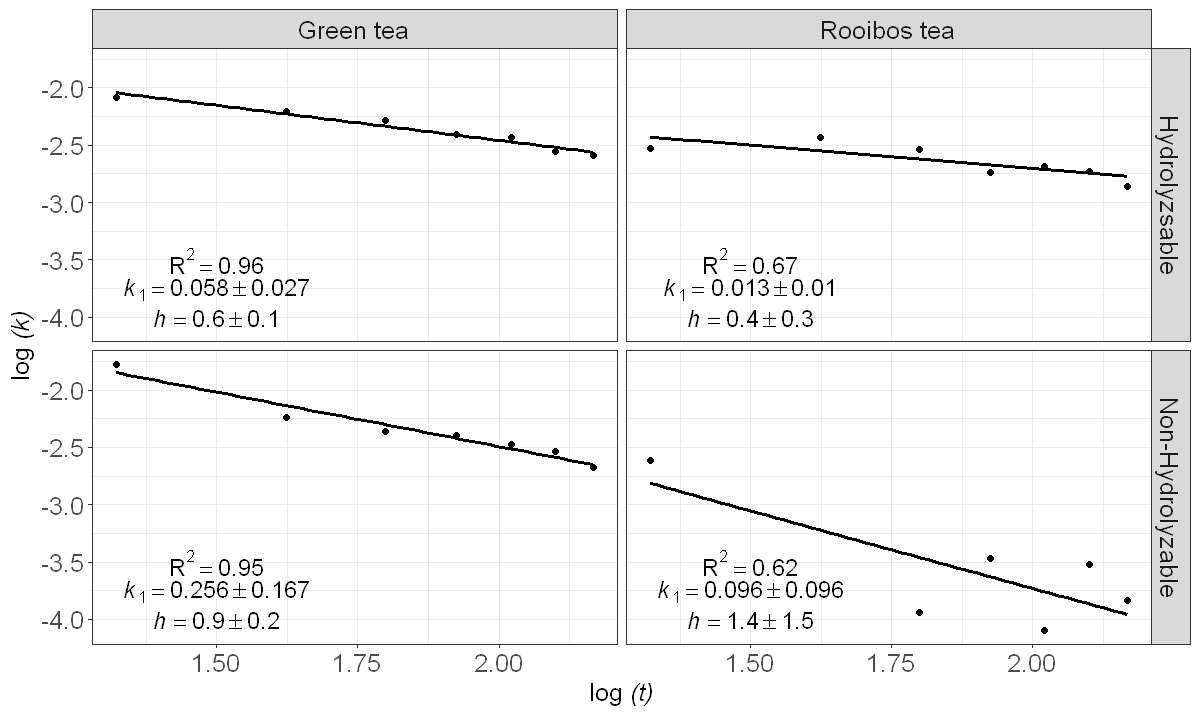

In [71]:
options(repr.plot.width = 10, repr.plot.height = 6)
data_median_fractal_biochemical %>%
  ggplot(aes(x = log.T, y  = log.K)) +
  geom_point() + geom_smooth(method = "lm", se = FALSE, colour="black") +
  facet_grid(`Biochemical composition` ~ `Biomass type`, labeller = labeller(`Biochemical composition` = New.labs)) +
  geom_text(data = fractal_biochemical_kinetics %>%
              rename(`Biochemical composition`= Biochemical_composition),
            parse = TRUE,
            aes(label = paste("italic(h) ==", round(h, 1), "%+-%", round(h-h_ll, 1))),
            x = 1.5, y = -4, size = 5) +
  geom_text(data = fractal_biochemical_kinetics%>%
              rename(`Biochemical composition`= Biochemical_composition),  
            parse = TRUE,
            aes(label = paste("italic(k[1]) ==", round(k1, 3), "%+-%", round(k1-k1_ll, 3))),
            x = 1.5, y = -3.75, size = 5) +

geom_text(data = fractal_biochemical_kinetics %>%
              rename(`Biochemical composition`= Biochemical_composition),
          parse = TRUE,
          aes(label = paste(("R^2 =="), round(r_sq, 2))),                 
           x = 1.5, y = -3.5, size = 5) + 
labs(x = expression(paste("log ", italic("(t)"))), y = expression(paste("log ", italic("(k)")))) +
  theme_bw() +
theme(strip.text = element_text(size = 15), axis.text=element_text(size=15),
        axis.title=element_text(size=15)) 
ggsave("figures/Fractal first order parameters of decomposition of teas biochemicals compositions under field conditions.png", width = 8, height = 6, dpi = 600)